In [271]:
import sys  
sys.path.insert(1, '../src')

import torch
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from VirtualCellLine import VirtualCellLine
from utils import verify_sine_dependency

In [228]:
def generate_toy_dataset(n_samples=10000, n_features=10, n_dependent_features=3, noise_level=0.1):
    """
    Generate a toy dataset with known dependencies between features.
    
    Args:
    n_samples (int): Number of samples in the dataset.
    n_features (int): Total number of features.
    n_dependent_features (int): Number of features with dependencies.
    noise_level (float): Level of noise to add to dependent features.
    
    Returns:
    pd.DataFrame: DataFrame containing the generated dataset.
    """
    
    # Generate independent features
    X = np.random.randn(n_samples, n_features)
    
    # Create dependencies
    dependent_features = []
    for i in range(n_dependent_features):
        # Choose a random feature to depend on
        dependent_on = np.random.randint(n_dependent_features, n_features)
        dependent_features.append(dependent_on)
        
        # Create a non-linear dependency
        X[:, i] = np.sin(X[:, dependent_on]) + np.random.normal(0, noise_level, n_samples)

    # # Create features dependent on several other features
    # for i in range(n_dependent_features, n_dependent_features + n_codependent_features):
    #     # Choose random features to depend on
    #     dependent_on = np.random.choice(np.arange(n_dependent_features), size=np.random.randint(1, n_dependent_features), replace=False)
    #     dependent_features.append(dependent_on)
        
    #     # Create a linear dependency
    #     X[:, i] = np.sum(X[:, dependent_on], axis=1) + np.random.normal(0, noise_level, n_samples)

    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Randomly zero out between 50% and 80% of the values in each sample
    mask = np.random.rand(*X_scaled.shape) < np.random.uniform(0.5, 0.5)
    X_scaled[mask] = 0
    
    # Convert to DataFrame
    df = pd.DataFrame(X_scaled, columns=[f'gene_{i}' for i in range(n_features)])

    dependencies = pd.DataFrame(dependent_features, columns=['dependent_on'])
    
    return df, dependencies

# Generate the dataset
df, dependencies = generate_toy_dataset()

# Print the first few rows and the dependencies
print(df.head())
print("\nKnown dependencies:")
for i, feature in enumerate(dependencies['dependent_on']):
    print(f"Feature {i} depends on feature {feature}")

# Save the dataset to a CSV file
df.to_csv('../data/toy_gene_expression_dataset.csv', index=False)

print("\nDataset saved to 'toy_gene_expression_dataset.csv'")

     gene_0  gene_1    gene_2    gene_3    gene_4    gene_5    gene_6  \
0  0.000000     0.0  0.773413  0.463065  0.444690  0.402440  0.634860   
1  0.000000     0.0  0.000000  0.000000  0.669420  0.000000  0.000000   
2  0.000000     0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3  0.000000     0.0  0.089413  0.000000  0.000000  0.000000  0.528409   
4  0.410429     0.0  0.000000  0.000000  0.316579  0.394154  0.414402   

     gene_7    gene_8    gene_9  
0  0.000000  0.000000  0.000000  
1  0.000000  0.214114  0.000000  
2  0.321172  0.304118  0.471788  
3  0.000000  0.000000  0.000000  
4  0.502774  0.000000  0.528577  

Known dependencies:
Feature 0 depends on feature 3
Feature 1 depends on feature 9
Feature 2 depends on feature 7

Dataset saved to 'toy_gene_expression_dataset.csv'


In [282]:
input_size = df.shape[1]
model = VirtualCellLine(input_size, embedding_dim=8, num_heads=8, num_transformer_layers=6, dropout_rate=0)
model.load_state_dict(torch.load('../autoencoder_20240731161511.pth'))
model.eval();

Correlation between true (noisy) values and predictions: 0.9492


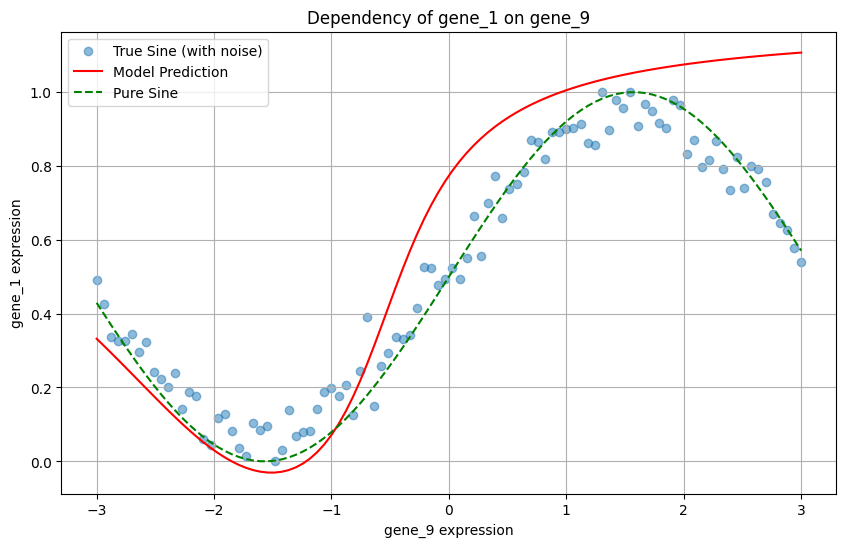

In [283]:
gene_target = 1
gene_source = dependencies['dependent_on'][gene_target]
verify_sine_dependency(model, gene_source=gene_source, gene_target=gene_target)

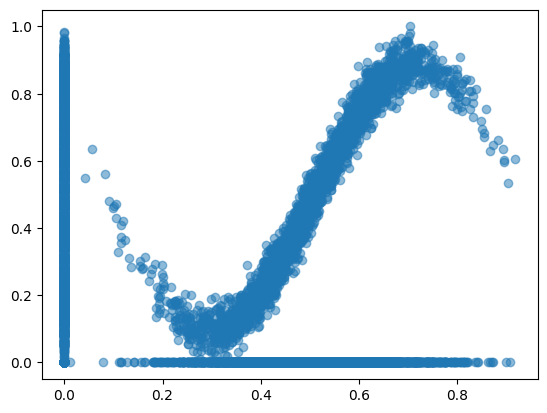

In [279]:
gene_target = 0
gene_source = dependencies['dependent_on'][gene_target]
plt.scatter(df[f'gene_{gene_source}'], df[f'gene_{gene_target}'], alpha=0.5);